In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report

In [2]:
df = pd.read_csv('dane/dane_stacja_600.csv')
df['data_pomiaru'] = pd.to_datetime(df['data_pomiaru'])

## 1. Regresja - przewidywanie temperatury

Początkowa próba przewidywania temperatury na podstawie tylko podstawowych parametrów meteorologicznych (prędkość wiatru, wilgotność względna, ciśnienie) okazała się mało skuteczna (R² = 0.24). Model wyjaśniał jedynie 24% zmienności temperatury, co wskazywało na pominięcie istotnych zależności.
```
X_reg = df[['predkosc_wiatru', 'wilgotnosc_wzgledna', 'cisnienie']]
y_reg = df['temperatura']
```

Kluczem do poprawy modelu było zrozumienie natury zjawiska, jakim jest temperatura powietrza. Temperatura wykazuje wyraźne wzorce dobowe i sezonowe, dlatego wprowadzono następujące modyfikacje:

jednak dane te nie były wystarczające do przewidywania temperatury. Dodałem więc odpowiednio przekształcone cechy, interakcje i zależności. 
1. Cykliczność czasu - wprowadziłem transformacje trygonometryczne dla godziny czasu i dnia w roku. Dzięki temu np temperatura o godz 23:00 jest bliższa 0:00 mimo że numerycznie jest bliżej np 12:00. Tak samo dni np 31 grudnia do 1 stycznia a nie do 1 lipca.
2. Wilgotność i ciśnienie w ciągu dnia też się zmienia w zależności od pory a nie tylko temperatury.
3. Uwzględnienie nielinowych zależności w ciśnieniu i wilgotności.

Te modyfikacje doprowadziły do znaczącej poprawy jakości modelu - współczynnik determinacji R² wzrósł do 0.80, co oznacza, że model wyjaśnia teraz 80% zmienności temperatury. Średni błąd kwadratowy (MSE) spadł z 49.77 do 13.11, co świadczy o znacznie dokładniejszych przewidywaniach.

Korekta została dokonana na etapie Regresji, ale ma ona też wpływ na resztę wyników modelowania.

In [15]:
# Cechy cykliczne dla godziny
hour_sin = np.sin(2 * np.pi * df['godzina_pomiaru']/24)
hour_cos = np.cos(2 * np.pi * df['godzina_pomiaru']/24)

# Cechy cykliczne dla dnia roku
day_of_year = df['data_pomiaru'].dt.dayofyear
day_sin = np.sin(2 * np.pi * day_of_year/365)
day_cos = np.cos(2 * np.pi * day_of_year/365)

X_reg = df[['predkosc_wiatru', 'wilgotnosc_wzgledna', 'cisnienie']].copy()

X_reg['hour_sin'] = hour_sin
X_reg['hour_cos'] = hour_cos
X_reg['day_sin'] = day_sin
X_reg['day_cos'] = day_cos
X_reg['humidity_hour'] = df['wilgotnosc_wzgledna'] * hour_sin
X_reg['pressure_hour'] = df['cisnienie'] * hour_sin
X_reg['pressure_squared'] = df['cisnienie']**2
X_reg['humidity_squared'] = df['wilgotnosc_wzgledna']**2

y_reg = df['temperatura']

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)


scaler_reg = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)

### 1.1 Regresja liniowa

Regresja liniowa:
Mean Squared Error: 13.11
R² Score: 0.80


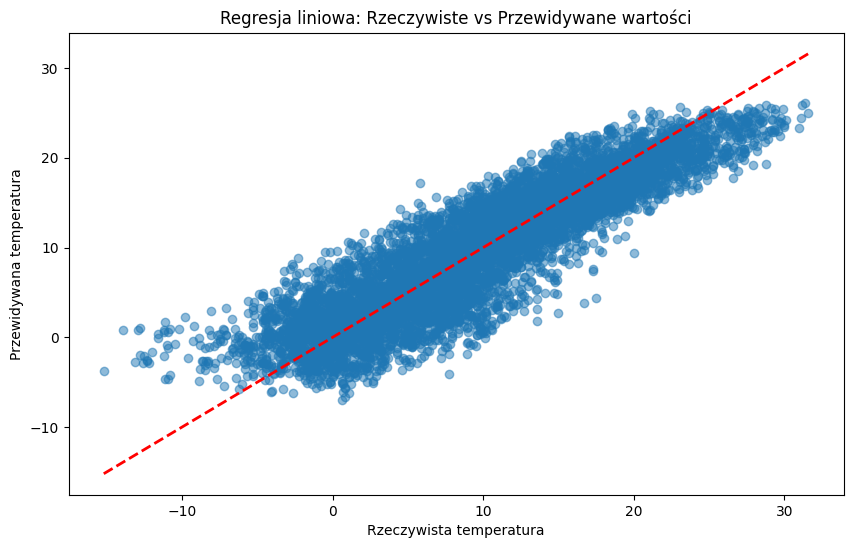


Wyniki 5-krotnej cross-walidacji (R²):
Średnia: 0.81 (+/- 0.01)


In [16]:
lr_model = LinearRegression()
lr_model.fit(X_train_reg_scaled, y_train_reg)

y_pred_lr = lr_model.predict(X_test_reg_scaled)

mse_lr = mean_squared_error(y_test_reg, y_pred_lr)
r2_lr = r2_score(y_test_reg, y_pred_lr)

print("Regresja liniowa:")
print(f"Mean Squared Error: {mse_lr:.2f}")
print(f"R² Score: {r2_lr:.2f}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test_reg, y_pred_lr, alpha=0.5)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
plt.xlabel('Rzeczywista temperatura')
plt.ylabel('Przewidywana temperatura')
plt.title('Regresja liniowa: Rzeczywiste vs Przewidywane wartości')
plt.show()

cv_scores_lr = cross_val_score(lr_model, X_train_reg_scaled, y_train_reg, cv=5, scoring='r2')
print("\nWyniki 5-krotnej cross-walidacji (R²):")
print(f"Średnia: {cv_scores_lr.mean():.2f} (+/- {cv_scores_lr.std() * 2:.2f})")


### 1.2 Las losowy (regresja)

Las losowy:
Mean Squared Error: 3.80
R² Score: 0.94


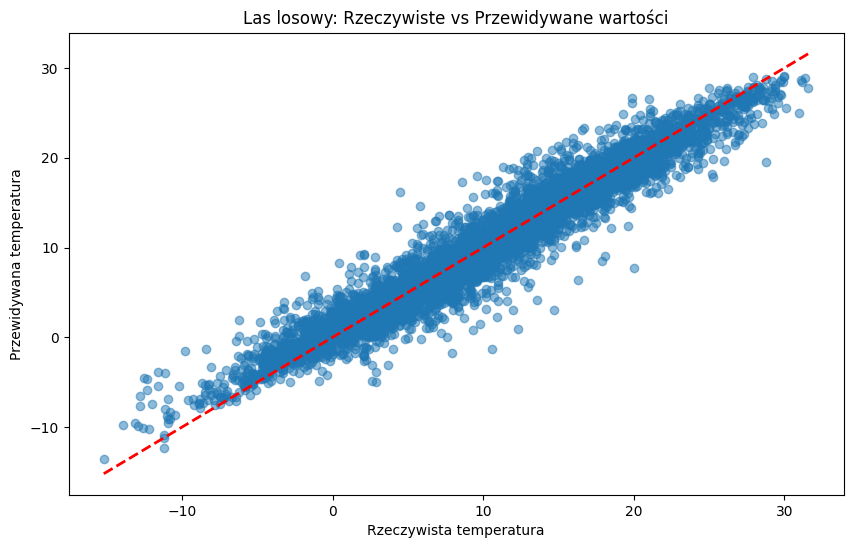


Wyniki 5-krotnej cross-walidacji (R²):
Średnia: 0.94 (+/- 0.00)


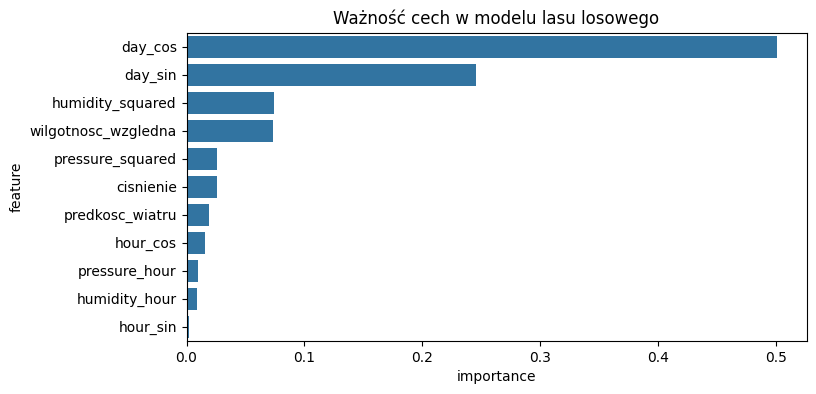

In [17]:
rf_model_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_reg.fit(X_train_reg_scaled, y_train_reg)

y_pred_rf = rf_model_reg.predict(X_test_reg_scaled)

mse_rf = mean_squared_error(y_test_reg, y_pred_rf)
r2_rf = r2_score(y_test_reg, y_pred_rf)

print("Las losowy:")
print(f"Mean Squared Error: {mse_rf:.2f}")
print(f"R² Score: {r2_rf:.2f}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test_reg, y_pred_rf, alpha=0.5)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
plt.xlabel('Rzeczywista temperatura')
plt.ylabel('Przewidywana temperatura')
plt.title('Las losowy: Rzeczywiste vs Przewidywane wartości')
plt.show()

cv_scores_rf = cross_val_score(rf_model_reg, X_train_reg_scaled, y_train_reg, cv=5, scoring='r2')
print("\nWyniki 5-krotnej cross-walidacji (R²):")
print(f"Średnia: {cv_scores_rf.mean():.2f} (+/- {cv_scores_rf.std() * 2:.2f})")

feature_importance = pd.DataFrame({
    'feature': X_reg.columns,
    'importance': rf_model_reg.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(8, 4))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Ważność cech w modelu lasu losowego')
plt.show()

## 2. Klasyfikacja - przewidywanie pory roku

In [26]:
X_clf = df[['temperatura', 'predkosc_wiatru', 'wilgotnosc_wzgledna', 'cisnienie']]
y_clf = df['data_pomiaru'].dt.month.map({
    12: 'Zima', 1: 'Zima', 2: 'Zima',
    3: 'Wiosna', 4: 'Wiosna', 5: 'Wiosna',
    6: 'Lato', 7: 'Lato', 8: 'Lato',
    9: 'Jesień', 10: 'Jesień', 11: 'Jesień'
})

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42
)

scaler_clf = StandardScaler()
X_train_clf_scaled = scaler_clf.fit_transform(X_train_clf)
X_test_clf_scaled = scaler_clf.transform(X_test_clf)

### 2.1 Drzewo decyzyjne

In [27]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_clf_scaled, y_train_clf)

y_pred_dt = dt_model.predict(X_test_clf_scaled)

accuracy_dt = accuracy_score(y_test_clf, y_pred_dt)
print("Drzewo decyzyjne:")
print(f"Dokładność (Accuracy): {accuracy_dt:.2f}")

print("\nSzczegółowy raport klasyfikacji:")
print(classification_report(y_test_clf, y_pred_dt))

cv_scores_dt = cross_val_score(dt_model, X_train_clf_scaled, y_train_clf, cv=5, scoring='accuracy')
print("\nWyniki 5-krotnej cross-walidacji (Accuracy):")
print(f"Średnia: {cv_scores_dt.mean():.2f} (+/- {cv_scores_dt.std() * 2:.2f})")


Drzewo decyzyjne:
Dokładność (Accuracy): 0.66

Szczegółowy raport klasyfikacji:
              precision    recall  f1-score   support

      Jesień       0.55      0.58      0.57      1765
        Lato       0.78      0.74      0.76      1759
      Wiosna       0.61      0.61      0.61      1809
        Zima       0.73      0.74      0.73      1680

    accuracy                           0.66      7013
   macro avg       0.67      0.67      0.67      7013
weighted avg       0.67      0.66      0.67      7013


Wyniki 5-krotnej cross-walidacji (Accuracy):
Średnia: 0.65 (+/- 0.02)


### 2.2 Las losowy (klasyfikacja)

Las losowy:
Dokładność (Accuracy): 0.73

Szczegółowy raport klasyfikacji:
              precision    recall  f1-score   support

      Jesień       0.67      0.62      0.64      1765
        Lato       0.81      0.85      0.83      1759
      Wiosna       0.68      0.66      0.67      1809
        Zima       0.76      0.81      0.78      1680

    accuracy                           0.73      7013
   macro avg       0.73      0.73      0.73      7013
weighted avg       0.73      0.73      0.73      7013


Wyniki 5-krotnej cross-walidacji (Accuracy):
Średnia: 0.72 (+/- 0.01)


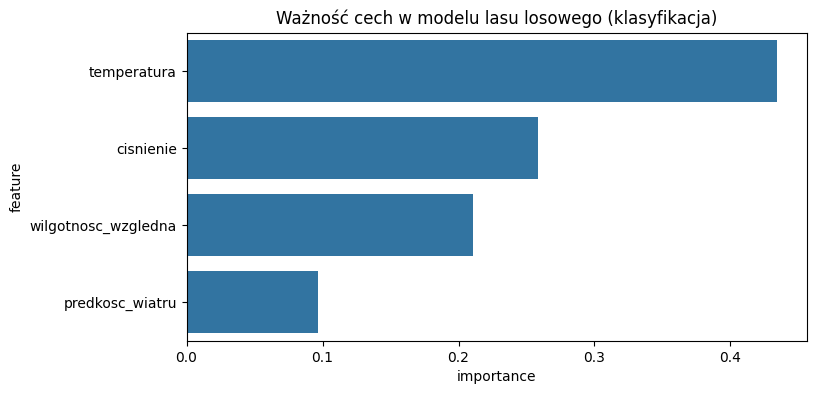

In [28]:
rf_model_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_clf.fit(X_train_clf_scaled, y_train_clf)

y_pred_rf_clf = rf_model_clf.predict(X_test_clf_scaled)

accuracy_rf = accuracy_score(y_test_clf, y_pred_rf_clf)
print("Las losowy:")
print(f"Dokładność (Accuracy): {accuracy_rf:.2f}")

print("\nSzczegółowy raport klasyfikacji:")
print(classification_report(y_test_clf, y_pred_rf_clf))

cv_scores_rf_clf = cross_val_score(rf_model_clf, X_train_clf_scaled, y_train_clf, cv=5, scoring='accuracy')
print("\nWyniki 5-krotnej cross-walidacji (Accuracy):")
print(f"Średnia: {cv_scores_rf_clf.mean():.2f} (+/- {cv_scores_rf_clf.std() * 2:.2f})")

feature_importance_clf = pd.DataFrame({
    'feature': X_clf.columns,
    'importance': rf_model_clf.feature_importances_
})
feature_importance_clf = feature_importance_clf.sort_values('importance', ascending=False)

plt.figure(figsize=(8, 4))
sns.barplot(data=feature_importance_clf, x='importance', y='feature')
plt.title('Ważność cech w modelu lasu losowego (klasyfikacja)')
plt.show()

### 2.3 Regresja logistyczna

In [30]:
lr_model_clf = LogisticRegression(max_iter=1000, random_state=42)
lr_model_clf.fit(X_train_clf_scaled, y_train_clf)

y_pred_lr_clf = lr_model_clf.predict(X_test_clf_scaled)

accuracy_lr = accuracy_score(y_test_clf, y_pred_lr_clf)
print("Regresja logistyczna:")
print(f"Dokładność (Accuracy): {accuracy_lr:.2f}")

print("\nSzczegółowy raport klasyfikacji:")
print(classification_report(y_test_clf, y_pred_lr_clf))

cv_scores_lr_clf = cross_val_score(lr_model_clf, X_train_clf_scaled, y_train_clf, cv=5, scoring='accuracy')
print("\nWyniki 5-krotnej cross-walidacji (Accuracy):")
print(f"Średnia: {cv_scores_lr_clf.mean():.2f} (+/- {cv_scores_lr_clf.std() * 2:.2f})")


Regresja logistyczna:
Dokładność (Accuracy): 0.62

Szczegółowy raport klasyfikacji:
              precision    recall  f1-score   support

      Jesień       0.49      0.46      0.48      1765
        Lato       0.75      0.81      0.78      1759
      Wiosna       0.55      0.46      0.50      1809
        Zima       0.64      0.75      0.69      1680

    accuracy                           0.62      7013
   macro avg       0.61      0.62      0.61      7013
weighted avg       0.61      0.62      0.61      7013


Wyniki 5-krotnej cross-walidacji (Accuracy):
Średnia: 0.63 (+/- 0.01)


## 3. Podsumowanie wyników

W przypadku przewidywania temperatury las losowy osiągnął lepszy wynik niż regresja liniowa, poniewa radzi on sobie z zależnościami nieliniowymi oraz ze złożonymi wzorcami, a także jest odporny na szum (który na pewno w tych danych jest).
Druga część badania to klasyfikacja pór roku. Widać tutaj, że największy wpływ na porę roku ma temperatura. W tym przypadku również las losowy osiągnął najlepszy wynik, ponieważ poradził on sobie z rozmytymi granicami między porami roku. 
Prawdopodobnie zebranie większej ilości danych pomogłoby w lepszym uchwyceniu wzorców sezonowych i radzeniu sobie z anomaliami pogodowymi.

In [31]:
print("Podsumowanie wyników regresji (R² Score):")
print(f"Regresja liniowa: {r2_lr:.3f}")
print(f"Las losowy: {r2_rf:.3f}")
print("\nPodsumowanie wyników klasyfikacji (Accuracy):")
print(f"Drzewo decyzyjne: {accuracy_dt:.3f}")
print(f"Las losowy: {accuracy_rf:.3f}")
print(f"Regresja logistyczna: {accuracy_lr:.3f}")

Podsumowanie wyników regresji (R² Score):
Regresja liniowa: 0.799
Las losowy: 0.942

Podsumowanie wyników klasyfikacji (Accuracy):
Drzewo decyzyjne: 0.665
Las losowy: 0.732
Regresja logistyczna: 0.617
